In [1]:
import pandas as pd
import numpy as np

from itertools import product

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import seaborn as sns

import scipy

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Recode partner for modeling
df['partner_recoded'] = df['partner'] - 1

###### Define some functions to make my life easier

In [3]:
def create_features(dataframe, y_var, X_vars):
    # Categorical variables
    categoricals = df.describe(include=[np.object])
    
    # Definine outcome and predictors.
    # Set our outcome to 0 and 1.
    y = dataframe[y_var]
    X = dataframe.loc[:, ~dataframe.columns.isin(categoricals) & dataframe.columns.isin(X_vars)]
    
    # Convert categorical variables into dummies
    for categorical_var in list(dataframe.describe(include=[np.object])):
        if categorical_var in X_vars:
            X = pd.concat([X, pd.get_dummies(dataframe[categorical_var])], axis=1)
     
    # Create training and test sets.
    offset = int(X.shape[0] * 0.9)

    # Put 90% of the data in the training set.
    X_train, y_train = X[:offset], y[:offset]

    # And put 10% in the test set.
    X_test, y_test = X[offset:], y[offset:]
        
    return {'X_train':X_train, 'y_train':y_train, 
            'X_test':X_test, 'y_test':y_test}

In [4]:
def accuracy_tables(model, data_dict):
    predict_train = model.predict(data_dict['X_train'])
    predict_test = model.predict(data_dict['X_test'])
    
    table_train = pd.crosstab(data_dict['y_train'], predict_train, margins=True)
    table_test = pd.crosstab(data_dict['y_test'], predict_test, margins=True)

    train_tI_errors = round(table_train.loc[0.0,1.0] /table_train.loc['All','All'],2)
    train_tII_errors = round(table_train.loc[1.0,0.0] /table_train.loc['All','All'],2)

    test_tI_errors = round(table_test.loc[0.0,1.0]/table_test.loc['All','All'],2)
    test_tII_errors = round(table_test.loc[1.0,0.0] / table_test.loc['All','All'],2)

    return {'train_tI_errors':train_tI_errors,
           'train_tII_errors':train_tII_errors,
           'test_tI_errors':test_tI_errors,
           'test_tII_errors':test_tII_errors}

In [5]:
def feature_importance(model,dataframe,X_vars):
    feature_importance = model.feature_importances_

    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, dataframe[X_vars].columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

## First iteration of model, from Thinkful curriculum

{'train_tI_errors': 0.05, 'train_tII_errors': 0.18, 'test_tI_errors': 0.07, 'test_tII_errors': 0.19}


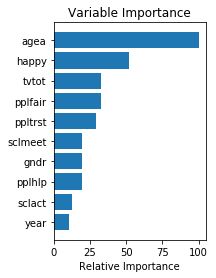

In [6]:
# Set the features
X_vars1 = ['year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 
          'sclmeet', 'sclact', 'gndr', 'agea']  

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
         'max_depth': 2,
         'loss': 'deviance'}

iter1_data = create_features(dataframe=df,
                             y_var='partner_recoded',
                             X_vars=X_vars1)

# Initialize and fit the model.
clf1 = ensemble.GradientBoostingClassifier(**params)
clf1.fit(iter1_data['X_train'], iter1_data['y_train'])

# Retrieve accuracy tables
print(accuracy_tables(clf1, iter1_data))

# Get feature importance
feature_importance(clf1, df, X_vars1)

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [7]:
# Let's try lots of permutations of strategies to see how low we can get our error
params2 = {'n_estimators': np.arange(100,800,200),
           'max_depth': np.arange(2,8,2),
           'loss':['deviance','exponential'],
           'subsample': np.arange(0.5,1.25,0.25)}

# Create a dataframe summarizing all these combinations of parameters
strategies = pd.DataFrame(list(product(params2['n_estimators'],
                                       params2['max_depth'],
                                       params2['loss'],
                                       params2['subsample'])), columns=list(params2.keys()))

In [8]:
# Define lists to store errors in
train_tI = []
test_tI = []
train_tII = []
test_tII = []

# Iterate through the permutations of parameters and retrieve error counts
for index in strategies.index:
    row_params = {'n_estimators':strategies.at[index, 'n_estimators'], 
                  'max_depth':strategies.at[index, 'max_depth'], 
                  'loss':strategies.at[index, 'loss'], 
                  'subsample':strategies.at[index, 'subsample']}
    
    # Initialize and fit the model.
    clf2 = ensemble.GradientBoostingClassifier(**row_params)
    clf2.fit(iter1_data['X_train'], iter1_data['y_train'])
    
    model_accuracy_table = accuracy_tables(clf2, iter1_data)
    
    train_tI.append(model_accuracy_table['train_tI_errors'])
    test_tI.append(model_accuracy_table['test_tI_errors'])
    train_tII.append(model_accuracy_table['train_tII_errors'])
    test_tII.append(model_accuracy_table['test_tII_errors'])



In [9]:
# Append the error counts to the dataframe
strategies['train_tI'] = train_tI
strategies['test_tI'] = test_tI
strategies['train_tII'] = train_tII
strategies['test_tII'] = test_tII

In [10]:
# Assign colors to each type of error for consistency between plots
training_colors = sns.color_palette("Blues", 8).as_hex()
test_colors= sns.color_palette("Reds", 8).as_hex()

colors = {'train_tI':training_colors[3], 
          'test_tI':test_colors[3], 
          'train_tII':training_colors[6],
          'test_tII':test_colors[6]}

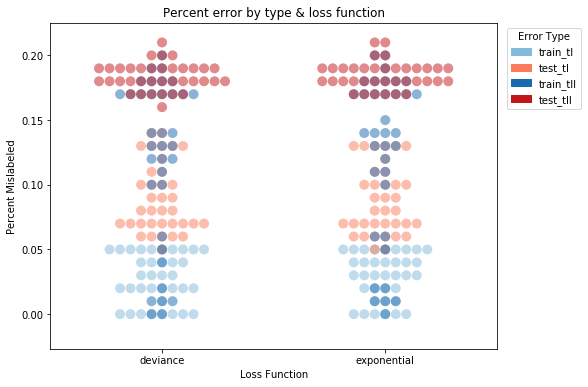

In [11]:
# Plot error by loss function
legend_entries = []

plt.figure(figsize=(8, 6))
for variable in ['train_tI', 'test_tI', 'train_tII', 'test_tII']:
    sns.swarmplot(x=strategies['loss'], 
                  y=strategies[variable], 
                  color=colors[variable], 
                  alpha=0.5, 
                  size=10)
    
    legend_entries.append(mpatches.Patch(color=colors[variable], label=variable))

plt.legend(handles=legend_entries, 
           loc="upper right",
           title='Error Type',
           bbox_to_anchor=(1.2, 1))

plt.xlabel('Loss Function')
plt.ylabel('Percent Mislabeled')
plt.title('Percent error by type & loss function')
plt.show()

###### I don't see a clear benefit to using either of these loss functions over the other.

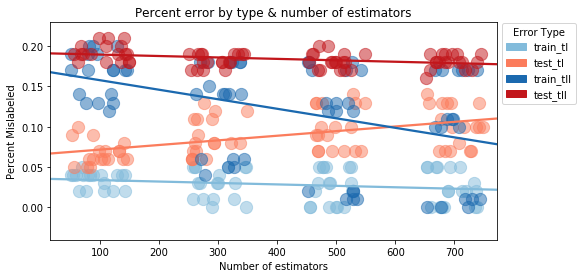

In [12]:
# Plot error by number of estimators
legend_entries = []

plt.figure(figsize=(8, 4))
for variable in ['train_tI', 'test_tI', 'train_tII', 'test_tII']:
    sns.regplot(x=strategies['n_estimators'], 
                y=strategies[variable],
                color=colors[variable],
                x_jitter=50,
                ci=False,
                scatter_kws={'alpha':0.5, 's':150})
    
    legend_entries.append(mpatches.Patch(color=colors[variable], label=variable))

plt.legend(handles=legend_entries, 
           loc="lower left",
           bbox_to_anchor=(1, .6),
           title='Error Type')

plt.xlabel('Number of estimators')
plt.ylabel('Percent Mislabeled')
plt.title('Percent error by type & number of estimators')
plt.show()

###### There's a tradeoff between type I and type II errors in the test sample with increased error estimators. The initial model offered by Thinkful skewed towards type I errors. This classification problem doesn't have a strong need for specificity over sensitivity or vice versa, so I think it makes sense to level them out a bit. Just eyeballing this plot, I think a reasonable compromise between the two types of error will occur at around 1000 estimators.

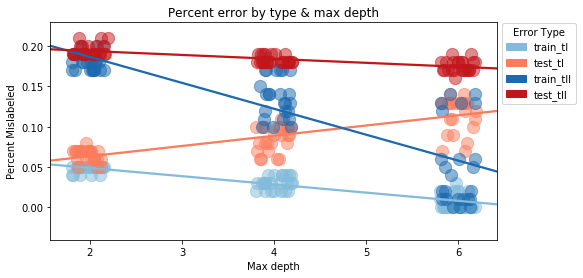

In [13]:
# Plot error by max depth
legend_entries = []

plt.figure(figsize=(8, 4))
for variable in ['train_tI', 'test_tI', 'train_tII', 'test_tII']:
    sns.regplot(x=strategies['max_depth'], 
                y=strategies[variable],
                color=colors[variable],
                ci=False,
                x_jitter=0.2,
                scatter_kws={'alpha':0.5, 's':150})
    
    legend_entries.append(mpatches.Patch(color=colors[variable], label=variable))

plt.legend(handles=legend_entries, 
           loc="lower left",
           bbox_to_anchor=(1, .6),
           title='Error Type')

plt.xlabel('Max depth')
plt.ylabel('Percent Mislabeled')
plt.title('Percent error by type & max depth')
plt.show()

###### Increasing depth seems to cause overfitting – both types of error dramatically drop off in the training data, but type I error leaps in the test data. Mean while, type II error slowly decreases with increasing depth. I'm going to move forward with a max depth of 6 – think the tradeoff is worth it, and I'll test that assumption with cross validation in my final model.

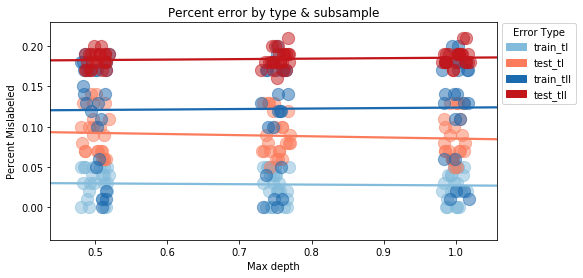

In [14]:
# Plot error by subsample
legend_entries = []

plt.figure(figsize=(8, 4))
for variable in ['train_tI', 'test_tI', 'train_tII', 'test_tII']:
    sns.regplot(x=strategies['subsample'], 
                y=strategies[variable],
                color=colors[variable],
                ci=False,
                x_jitter=.02,
                scatter_kws={'alpha':0.5, 's':150})
    
    legend_entries.append(mpatches.Patch(color=colors[variable], label=variable))

plt.legend(handles=legend_entries, 
           loc="lower left",
           bbox_to_anchor=(1, .6),
           title='Error Type')

plt.xlabel('Max depth')
plt.ylabel('Percent Mislabeled')
plt.title('Percent error by type & subsample')
plt.show()

##### I'm not seeing any huge distinctions between the depths; it seems like a subsample value closer to 1 might cause decreased error, but it could just be noise.

###### I'm going to try to minimize type II error in the test set; it seems like it's the 

In [15]:
best_scorers = strategies[(strategies['train_tI'] == strategies['train_tI'].min())
                          | (strategies['test_tI'] == strategies['test_tI'].min())
                          | (strategies['train_tII'] == strategies['train_tII'].min())
                          | (strategies['test_tII'] == strategies['test_tII'].min())]

best_scorers.sort_values(by='test_tII').head()

,n_estimators,max_depth,loss,subsample,train_tI,test_tI,train_tII,test_tII
67,700,6,deviance,0.75,0.0,0.13,0.00,0.16
51,500,6,exponential,0.50,0.0,0.13,0.02,0.17
69,700,6,exponential,0.50,0.0,0.13,0.01,0.17
31,300,6,deviance,0.75,0.0,0.12,0.04,0.17
48,500,6,deviance,0.50,0.0,0.14,0.01,0.17


{'train_tI_errors': 0.0, 'train_tII_errors': 0.0, 'test_tI_errors': 0.13, 'test_tII_errors': 0.17}


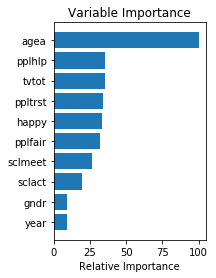

In [16]:
# Set the features
X_vars2 = ['year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 
          'sclmeet', 'sclact', 'gndr', 'agea']  

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 750,
         'max_depth': 6,
         'loss': 'deviance',
         'subsample':0.75}

iter2_data = create_features(dataframe=df,
                             y_var='partner_recoded',
                             X_vars=X_vars1)

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params)
clf2.fit(iter2_data['X_train'], iter2_data['y_train'])

# Retrieve accuracy tables
print(accuracy_tables(clf2, iter2_data))

# Get feature importance
feature_importance(clf2, df, X_vars2)

###### SUMMARY HERE

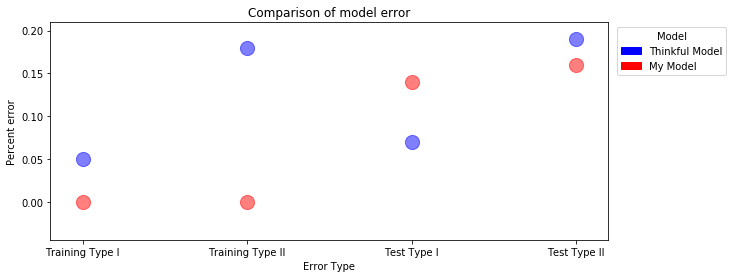

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.scatter(x=[1,2,3,4], y =[0, 0, 0.14, 0.16], color='red', s=200, alpha=0.5)
plt.scatter(x=[1,2,3,4], y =[0.05, 0.18, 0.07, 0.19], color='blue', s=200, alpha=0.5)

ax.set_xticks(np.arange(1,5,1))
ax.set_xticklabels(['Training Type I', 'Training Type II', 'Test Type I', 'Test Type II'])

handles = [mpatches.Patch(color='blue', label='Thinkful Model'), mpatches.Patch(color='red', label='My Model')]

plt.legend(handles=handles, 
           loc="upper right",
           title='Model',
           bbox_to_anchor=(1.22, 1))

plt.xlabel('Error Type')
plt.ylabel('Percent error')
plt.title('Comparison of model error')
plt.show()


###### Ok, so far I'm doing a little bit better than the Thinkful model, but I think there's room for improvement. I'm going to try to improve on the features a little bit. Age seems to be the primary driver of the model, which makes sense – people in certain age brackets are more likely to have a partner than in certain others. I'm going to see what happens if I convert the numeric age variable to standard age segmentation

In [18]:
# Define the age ranges of my recoded variables
age_dict = {'12-17':(12,17),
            '18-24':(18,24),
            '25-34':(25,34),
            '35-44':(35,44),
            '45-54':(45,54),
            '55-64':(55,64),
            '65+':(65,120)
           }


# Create a function that can convert float values to categorical strings
def variable_converter(x):
    for key in age_dict.keys():
        if x in np.arange(age_dict[key][0],(age_dict[key][1]+1),1):
            return key
        
# Create a new column that contains the recoded age variable, then convert it to dummies.
df['age_recoded'] = df['agea'].apply(lambda x: variable_converter(x))
df = pd.get_dummies(df, columns=['age_recoded'], prefix='age')

###### I'm also going to try recoding all of the "social" variables as binary high/low features based on the 75th percentile.

In [50]:
scaled_variables = ['ppltrst', 'pplfair', 'pplhlp', 'sclmeet', 'sclact', 'tvtot']

for variable in scaled_variables:
    df[variable + '_high'] = np.where(df[variable]>= df[variable].quantile(0.75), 1, 0)

{'train_tI_errors': 0.0, 'train_tII_errors': 0.0, 'test_tI_errors': 0.14, 'test_tII_errors': 0.17}


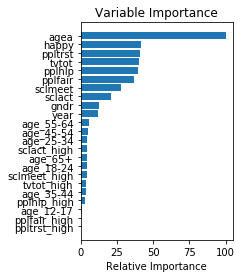

In [56]:
# Set the features
X_vars3 = ['year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet', 'sclact', 'gndr', 'agea'] + [item + '_high' for item in scaled_variables] + [ 'age_' + item for item in age_dict.keys()]

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params3 = {'n_estimators': 750,
         'max_depth': 6,
         'loss': 'deviance',
         'subsample':0.75}

iter3_data = create_features(dataframe=df,
                             y_var='partner_recoded',
                             X_vars=X_vars3)

# Initialize and fit the model.
clf3 = ensemble.GradientBoostingClassifier(**params3)
clf3.fit(iter3_data['X_train'], iter3_data['y_train'])

# Retrieve accuracy tables
print(accuracy_tables(clf3, iter3_data))

# Get feature importance
feature_importance(clf3, df, X_vars3)

###### That didn't change much, and certainly not for the better! Do you have any advice about how to engineer features that would provide some lift here?